In [1]:
import numpy as np     
import pandas as pd                   
import matplotlib.pyplot as plt
from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## Content:
This file is about calculating the loss and purity per zernike maps for both the LG22 and HG33 mode.

### Note:
There are different ways of calculating the loss and purity, other methods are done in file 'Different ways to calculate mode loss and purity(LG22 and HG33).ipynb'. The results are compared in that file to be the same.

In [2]:
#clipping loss of 1ppm
katHG33 = pykat.finesse.kat()
katHG33.verbose=False
katHG33.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 3.8 n3 n4

#higher order mode TEM33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2679.93
attr ETM Rc 2679.93
#Rc=2679.93 when clipping loss is 1ppm for HG33

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock


maxtem 8

""")

In [3]:
#clipping loss of 1ppm
katLG22 = pykat.finesse.kat()
katLG22.verbose=False
katLG22.parse("""

l laser 1 0 0 n0
#gauss g1 laser n0 1m 0
maxtem 8

s s0 1 n0 nmod1
mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1
m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 26.5 n3 n4

#higher order mode LG22
tem laser 0 0 0 0
tem laser 6 0 0.234375 0
tem laser 5 1 0.15625 -90
tem laser 4 2 0.015625 0
tem laser 3 3 0.1875 -90
tem laser 2 4 0.015625 180
tem laser 1 5 0.15625 -90
tem laser 0 6 0.234375 180

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2789.58
attr ETM Rc 2789.58
#Rc=2789.58 when clipping loss is 1ppm for LG22

pd1 pdh 60M 0 n1
set err pdh re
lock clock $err 1 1n
put* ETM phi $clock

""")

In [4]:
# The power seems to go up by a little bit when applying a map
# So I use the zero map as the reference when calculating loss instead of no map(otherwise the loss might be smaller than zero)

LG22nomap = katLG22.deepcopy()
LG22nomap.parse("""
        pd Pcirc n3
        """)
LG22nomap.noxaxis = True
outLGnomap=LG22nomap.run()
powernomap=outLGnomap["Pcirc"]

LG22zeromap = katLG22.deepcopy()
LG22zeromap.parse("""
        map ETM Znmmaps/Z22order0phasemap.txt
        pd Pcirc n3
        """)
LG22zeromap.noxaxis = True
outLGzeromap=LG22zeromap.run()
powerzeromap=outLGzeromap["Pcirc"]

LG22map = katLG22.deepcopy()
LG22map.parse("""
        map ETM Znmmaps/Z66order1phasemap.txt
        pd Pcirc n3
        """)
LG22map.noxaxis = True
outLGmap=LG22map.run()
powermap=outLGmap["Pcirc"]

print(f" The circulating Power with map is {powermap} \n The circulating Power with zero map is {powerzeromap} \n \
The circulating Power without map is {powernomap}")

 The circulating Power with map is 269.362269781898 
 The circulating Power with zero map is 269.514016825473 
 The circulating Power without map is 268.086866624925


In [4]:
# To create a prefect LG22 basis to calculate the purity
LG22nomap = katLG22.deepcopy()  
LG22nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outLGnomap=LG22nomap.run()
beamLGnomap=outLGnomap["ccd"]


# The power when applying null map. This is used to calculate the loss
LG22zeromap = katLG22.deepcopy()
LG22zeromap.parse("""
        map ETM Znmmaps/Z22order0phasemap.txt
        pd Pcirc n3
        """)
LG22zeromap.noxaxis = True
outLGzeromap=LG22zeromap.run()
powerzeromap=outLGzeromap["Pcirc"]


pkLG=parakat()
for n in range(7):
    for m in range(-n,n+1,2):
        LG22beam = katLG22.deepcopy()
        LG22beam.parse(f"""
                map ETM Znmmaps/Z{n}{m}order1phasemap.txt
                beam ccd 0 n3
                xaxis ccd x lin -7 7 200
                x2axis ccd y lin -7 7 200
                yaxis abs:deg
                pd Pcirc n3
                """)
        pkLG.run(LG22beam)
outLGmap = pkLG.getResults()


# Projecting the measured beam profile into LG22 basis(beamLGnomap) to get the purity
# and use the purity and measured power to get the loss
LGpurity=[]
LGloss=[]
for i in range(28):
    beamLGmap=outLGmap[i]['ccd']
    powermap=outLGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamLGmap)*beamLGnomap)*np.sum(np.conj(beamLGnomap)*beamLGmap))
    b=np.sum(np.abs(beamLGmap)**2)
    c=np.sum(np.abs(beamLGnomap)**2)
    purity=np.sqrt(a/(b*c))
    
    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    LGpurity.append(purity)
    LGloss.append(loss)
    
pd.Series(LGpurity).to_pickle('pkl/LG22purity.pkl')
pd.Series(LGloss).to_pickle('pkl/LG22loss.pkl')

/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2114: UserWarning: 'KatRun2D' does not have attribute called 'katPath'
  r.katPath = kat_exec
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2345: UserWarning: 'KatRun2D' does not have attribute called 'save_output'
  r.save_output = save_output
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2362: UserWarning: 'KatRun2D' does not have attribute called 'save_input'
  r.save_input = save_kat
/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

In [4]:
# To create a prefect HG33 basis to calculate the purity
HG33nomap = katHG33.deepcopy() 
HG33nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outHGnomap=HG33nomap.run()
beamHGnomap=outHGnomap["ccd"]


# The power when applying null map. This is used to calculate the loss
HG33zeromap = katHG33.deepcopy()
HG33zeromap.parse("""
        map ETM Znmmaps/Z22order0phasemap.txt
        pd Pcirc n3
        """)
HG33zeromap.noxaxis = True
outHGzeromap=HG33zeromap.run()
powerzeromap=outHGzeromap["Pcirc"]


pkHG=parakat()
for n in range(7):
    for m in range(-n,n+1,2):
        HG33beam = katHG33.deepcopy()
        HG33beam.parse(f"""
                map ETM Znmmaps/Z{n}{m}order1phasemap.txt
                beam ccd 0 n3
                xaxis ccd x lin -7 7 200
                x2axis ccd y lin -7 7 200
                yaxis abs:deg
                pd Pcirc n3
                """)
        pkHG.run(HG33beam)
outHGmap = pkHG.getResults()


# Projecting the measured beam profile into HG33 basis(beamHGnomap) to get the purity
# and use the purity and measured power to get the loss

HGpurity=[]
HGloss=[]
for i in range(28):
    beamHGmap=outHGmap[i]['ccd']
    powermap=outHGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamHGmap)*beamHGnomap)*np.sum(np.conj(beamHGnomap)*beamHGmap))
    b=np.sum(np.abs(beamHGmap)**2)
    c=np.sum(np.abs(beamHGnomap)**2)
    purity=np.sqrt(a/(b*c))
    
    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    HGpurity.append(purity)
    HGloss.append(loss)

pd.Series(HGpurity).to_pickle('pkl/HG33purity.pkl')
pd.Series(HGloss).to_pickle('pkl/HG33loss.pkl')

/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2114: UserWarning: 'KatRun2D' does not have attribute called 'katPath'
  r.katPath = kat_exec
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2345: UserWarning: 'KatRun2D' does not have attribute called 'save_output'
  r.save_output = save_output
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2362: UserWarning: 'KatRun2D' does not have attribute called 'save_input'
  r.save_input = save_kat
/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

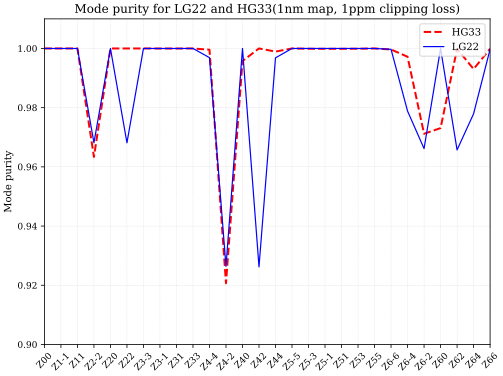

In [5]:
HG33purityZnm_array=pd.read_pickle('pkl/HG33purity.pkl').values
LG22purityZnm_array=pd.read_pickle('pkl/LG22purity.pkl').values

xticks=['Z00','Z1-1','Z11','Z2-2','Z20','Z22','Z3-3','Z3-1','Z31','Z33','Z4-4','Z4-2','Z40','Z42','Z44','Z5-5','Z5-3','Z5-1','Z51','Z53','Z55','Z6-6','Z6-4','Z6-2','Z60','Z62','Z64','Z66']
fig,ax =plt.subplots(figsize=(8,6))
ax.plot(HG33purityZnm_array,'r--',label='HG33', linewidth=2)
ax.plot(LG22purityZnm_array,'b',label='LG22')
ax.set_ylabel("Mode purity")
ax.set_title("Mode purity for LG22 and HG33(1nm map, 1ppm clipping loss)")
ax.set_ylim(0.9,1.01)
ax.set_xticks(range(28))
ax.set_xticklabels(xticks,rotation=45, fontsize=9)
ax.legend(loc='upper right')
#fig.savefig('../purityzernikes.pdf')
plt.show()

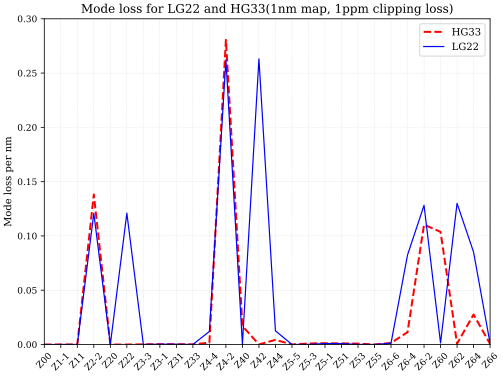

In [6]:
LG22lossZnm_array=pd.read_pickle('pkl/LG22loss.pkl').values
HG33lossZnm_array=pd.read_pickle('pkl/HG33loss.pkl').values

xticks=['Z00','Z1-1','Z11','Z2-2','Z20','Z22','Z3-3','Z3-1','Z31','Z33','Z4-4','Z4-2','Z40','Z42','Z44','Z5-5','Z5-3','Z5-1','Z51','Z53','Z55','Z6-6','Z6-4','Z6-2','Z60','Z62','Z64','Z66']
fig,ax =plt.subplots(figsize=(8,6))
ax.plot(HG33lossZnm_array,'r--',label='HG33', linewidth=2)
ax.plot(LG22lossZnm_array,'b',label='LG22')
ax.set_ylabel("Mode loss per nm")
ax.set_title("Mode loss for LG22 and HG33(1nm map, 1ppm clipping loss)")
ax.set_ylim(0,0.3)
ax.set_xticks(range(28))
ax.set_xticklabels(xticks,rotation=45, fontsize=9)
ax.legend(loc='upper right')
#fig.savefig('../losszernikes.pdf')
plt.show()

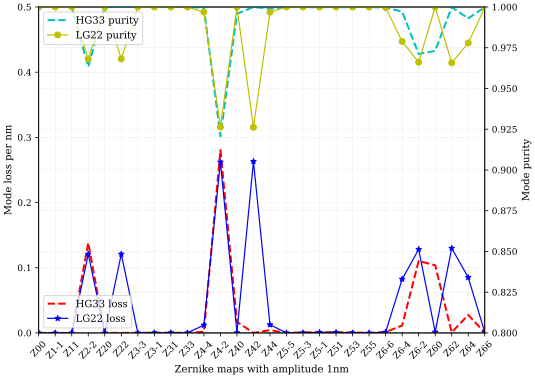

In [20]:
# put the two plots together as a single plot with two y axis
HG33purityZnm_array=pd.read_pickle('pkl/HG33purity.pkl').values
LG22purityZnm_array=pd.read_pickle('pkl/LG22purity.pkl').values
LG22lossZnm_array=pd.read_pickle('pkl/LG22loss.pkl').values
HG33lossZnm_array=pd.read_pickle('pkl/HG33loss.pkl').values

xticks=['Z00','Z1-1','Z11','Z2-2','Z20','Z22','Z3-3','Z3-1','Z31','Z33','Z4-4','Z4-2','Z40','Z42','Z44','Z5-5','Z5-3','Z5-1','Z51','Z53','Z55','Z6-6','Z6-4','Z6-2','Z60','Z62','Z64','Z66']
fig,ax =plt.subplots(figsize=(8,6))
ax.plot(HG33lossZnm_array,'r--',label='HG33 loss',linewidth=2)
ax.plot(LG22lossZnm_array,'b-*',label='LG22 loss')
ax.set_ylabel("Mode loss per nm")
ax.set_xlabel("Zernike maps with amplitude 1nm")
#ax.set_title("Mode loss for LG22 and HG33(1nm map, 1ppm clipping loss)")
ax.set_ylim(0,0.5)
ax.set_xticks(range(28))
ax.set_xticklabels(xticks,rotation=45, fontsize=9)
ax.legend(loc='lower left')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(HG33purityZnm_array,'c--',label='HG33 purity',linewidth=2)
ax2.plot(LG22purityZnm_array,'y-o',label='LG22 purity')
ax2.set_ylabel("Mode purity")
ax2.legend(loc='upper left')
ax2.set_ylim(0.8,1)
# save the plot as a file
fig.savefig('../lossandpurityzernikes.pdf')